# Assignment 2 - Question 2
The objective of this assignment is to get you familiarize with  the  problem  of  `Linear Regression`.

## Instructions
- Write your code and analysis in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of other cells.
- No inbuilt functions to be used until specified

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>_Assignment2_Q2.ipynb`.

## 2.0 Background about the dataset

TLDR: You have 4 independent variables (`float`) for each molecule. You can use a linear combination of these 4 independent variables to predict the bandgap (dependent variable) of each molecule.

You can read more about the problem in [Li et al, Bandgap tuning strategy by cations and halide ions of lead halide perovskites learned from machine learning, RSC Adv., 2021,11, 15688-15694](https://doi.org/10.1039/D1RA03117A).

In [1]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
all_molecules = list()

with open('bg_data.txt', 'r') as infile:
    input_rows = csv.DictReader(infile)
    
    for row in input_rows:
        current_mol = ([float(row['Cs']), float(row['FA']), float(row['Cl']), float(row['Br'])], float(row['Bandgap']))
        all_molecules.append(current_mol)

random.shuffle(all_molecules)


num_train = int(len(all_molecules) * 0.8)

# each point in x_train has 4 values - 1 for each feature
x_train = [x[0] for x in all_molecules[:num_train]]
# each point in y_train has 1 value - the bandgap of the molecule
y_train = [x[1] for x in all_molecules[:num_train]]

x_test = [x[0] for x in all_molecules[num_train:]]
y_test = [x[1] for x in all_molecules[num_train:]]

In [85]:
X = np.array(x_train, dtype='float32')
y = np.array(y_train, dtype='float32')

X = np.append(X, np.ones((X.shape[0], 1)), axis=1)
X.shape

(87, 5)

### 2.1 Implement a Linear Regression model that minimizes the MSE **without using any libraries**. You may use NumPy to vectorize your code, but *do not use numpy.polyfit* or anything similar.

2.1.1 Explain how you plan to implement Linear Regression in 5-10 lines.

I plan to implement linear regression by taking a weight vector *(in my case of dimension (1, 5), including the intercept term)*, which i plan to fit to the training data using the gradient descent algorithm. Gradient descent will help me reduce the model loss to a sufficient extent, where my linear regression model will be ready. I choose a particular learning rate for the linear regression model, which would be the value by which i will update my weights at each step of gradient descent. I keep updating the weights till:
- MSE converges, i.e doesn't change b magnitude of some epsilon (in my case 1e-7)
- Or my `num_epochs` are done  

Once this process is over, my weights have been trained on the data and can be used for prediction.

2.1.2 Implement Linear Regression using `x_train` and `y_train` as the train dataset.

2.1.2.1 Choose the best learning rate and print the learning rate for which you achieved the best MSE.

In [86]:
class LinearRegressor:
    def __init__(self, lr=1):
        self.lr = lr
        self._coef = None
        self.intercept = None
        self.mse = None
        self.mse_list = [1e7]
        self.mse_conv = 1e-7
        self.X = None
        self.y = None
    
    def _loss_function(self):
        self.mse = ((np.matmul(self.X, self._coef) - self.y).T@(np.matmul(self.X, self._coef) - self.y)) / (2 * self.X.shape[0])
    
    def _gradient(self):
        return (self.X.T@(np.matmul(self.X, self._coef) - self.y)) / (self.X.shape[0])

    def fit(self, X, y, num_epochs=10):
        self.X = np.array(X, dtype='float32')
        self.X = np.append(self.X, np.ones((self.X.shape[0], 1)), axis=1)
        self.y = np.array(y, dtype='float32')
        
        self._coef = np.random.rand(self.X.shape[1])
        for _ in range(num_epochs):
            grad = self._gradient()
            self._coef = self._coef - self.lr * grad
            self._loss_function()
            if abs(self.mse - self.mse_list[-1]) < self.mse_conv:
                break
            self.mse_list.append(self.mse)
        self.intercept = self._coef[-1]
    
    def predict(self, X):
        X_vec = np.array(X, dtype='float32')
        X_vec = np.append(X_vec, np.ones((X_vec.shape[0], 1)), axis=1)
        preds = np.matmul(X_vec, self._coef)
        return preds

Text(0, 0.5, 'MSE')

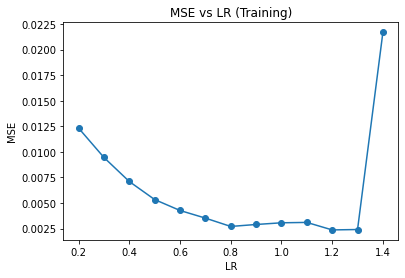

In [67]:
lr_list = np.arange(0.2, 1.5, 0.1)
mse_list = []
for lr in lr_list:
    regressor = LinearRegressor(lr=lr)
    regressor.fit(x_train, y_train, num_epochs=100)
    mse_list.append(regressor.mse)

plt.plot(lr_list, mse_list, marker='o')
plt.title("MSE vs LR (Training)")
plt.xlabel("LR")
plt.ylabel("MSE")

100%|██████████| 1001/1001 [00:05<00:00, 166.94it/s]


Text(0, 0.5, 'MSE')

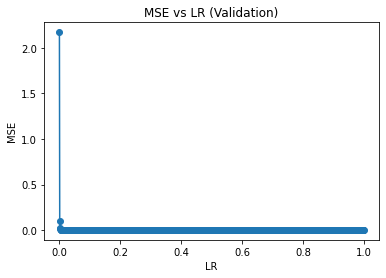

In [87]:
lr_list = np.arange(0.0, 1.001, 0.001)
y_test = np.array(y_test, dtype='float32')
mse_list = []

for i in tqdm(range(len(lr_list))):
    regressor = LinearRegressor(lr=lr_list[i])
    regressor.fit(x_train, y_train, num_epochs=10000)
    preds = regressor.predict(x_test)
    mse_list.append(((preds - y_test).T@(preds - y_test)) / (preds.shape[0]))

plt.plot(lr_list, mse_list, marker='o')
plt.title("MSE vs LR (Validation)")
plt.xlabel("LR")
plt.ylabel("MSE")

In [88]:
print(f"LR: {lr_list.tolist()[mse_list.index(min(mse_list))]}, MSE: {min(mse_list)}")

LR: 0.707, MSE: 0.0025383804697099183


In [91]:
regressor = LinearRegressor(lr=0.707)
regressor.fit(x_train, y_train, num_epochs=10000)

In [92]:
print(f"weights: {regressor._coef[:-1]}, intercept: {regressor.intercept}")

weights: [-0.03250028 -0.11130948  1.53756324  0.65392833], intercept: 1.5919985828531589


2.1.3 Make a [Parity Plot](https://en.wikipedia.org/wiki/Parity_plot) of your model's bandgap predictions on the test set with the actual values.

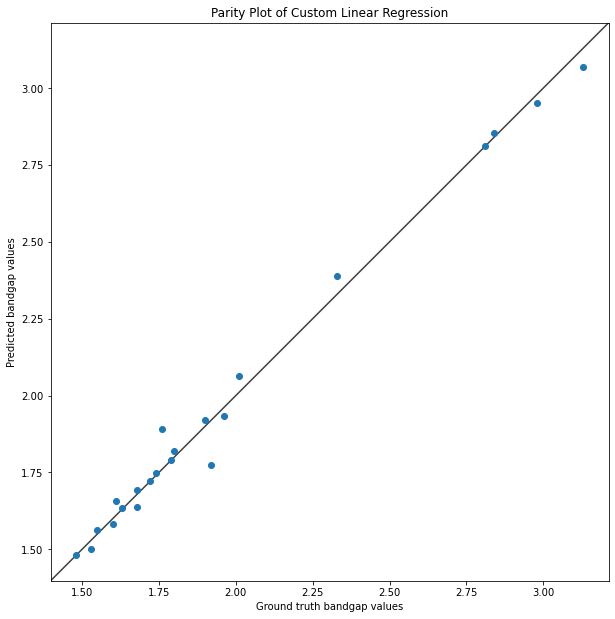

In [93]:
y_pred = regressor.predict(x_test)

fig, ax = plt.subplots(figsize=(10,20))
ax.scatter(y_test, y_pred)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_title('Parity Plot of Custom Linear Regression')
ax.set_xlabel('Ground truth bandgap values')
ax.set_ylabel('Predicted bandgap values')
plt.show()

### 2.2 Implement Ridge regression
2.2.1 Explain Ridge regression briefly in 1-2 lines.

Ridge regression is a modification to the standard linear regression algorithm where we add an additional factor of $\alpha||W||^2_2$ where $W$ is the weight vector and $\alpha$ is the regularization factor. The $\alpha$ term regularizes the weights such that larger values of weights are penalized (*higher loss value*). This helps reduce the model complexity and multi-collinearity (*high inter-dependence between the weights*).

2.2.2 Implement Ridge regression and make a table of different RMSE scores you achieved with different values of alpha. What does the parameter `alpha` do? How does it affect the results here? Explain in 5-10 lines in total. (You can use scikit-learn from this cell onwards)

Text(0, 0.5, 'MSE')

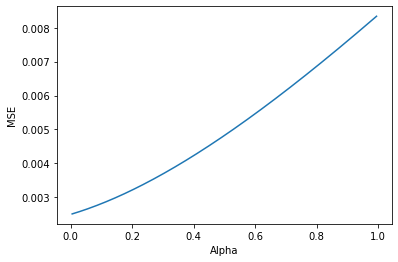

In [16]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

alpha = np.arange(0.005, 1, 0.005)
mse_list = []
for aph in alpha:
    clf = Ridge(alpha=aph)
    clf.fit(x_train, y_train)
    preds = clf.predict(x_test)
    mse_list.append(mean_squared_error(y_test, preds))

plt.plot(alpha, mse_list)
plt.xlabel('Alpha')
plt.ylabel('MSE')

The parameter `alpha` is the regularization factor. It regularizes the weights of the regression model by punishing higher weight values (*due to the higher loss*). We can see from the above graph that the MSE increases for increasing `alpha`. This implies that there are not many outliers in the given data and regularization would not help.

### 2.3 Implement Lasso regression
2.3.1 Explain Lasso regression briefly in 1-2 lines.

Lasso regression is also a modification to the standard linear regression algorithm where we add an additional factor of $\alpha||W||$ where $W$ is the weight vector and $\alpha$ is the regularization factor. Lasso regression is different from Ridge that instead of taking the L2 norm, we take the L1 norm of the weights. Since its just the L1 norm, its tends to make some weights absolute zero, which helps in feature extraction also (*something ridge regression cannot do, due to L2 Norm*)

2.3.2 Implement Lasso regression and make a table of different RMSE scores you achieved with different values of alpha. What does the parameter `alpha` do? How does it affect the results here? Explain in 5-10 lines in total.

Text(0, 0.5, 'MSE')

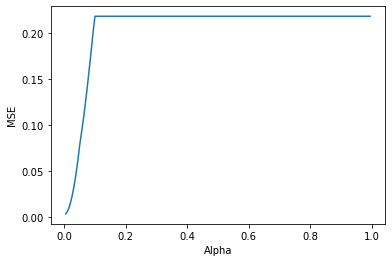

In [14]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

alpha = np.arange(0.005, 1, 0.005)
mse_list = []
for aph in alpha:
    clf = Lasso(alpha=aph)
    clf.fit(x_train, y_train)
    preds = clf.predict(x_test)
    mse_list.append(mean_squared_error(y_test, preds))

plt.plot(alpha, mse_list)
plt.xlabel('Alpha')
plt.ylabel('MSE')

The parameter `alpha` is the regularization factor. It regularizes the weights of the regression model by punishing higher weight values (*due to the higher loss*) and additionally as it uses L1 norm, it also helps remove less important weights (*reduces them to zero*). We can see from the above graph that the MSE increases for increasing `alpha` and then gets constant at around $0.1$. This implies that the data is already centred, and there are not many outliers in the given data, so regularization makes the performance worse.